For maximum EVI value and MAximum EVI date

In [6]:

from osgeo import gdal, osr
import numpy 
import subprocess
from subprocess import PIPE, Popen
import os
import math

def quicksort(seq):
    if len(seq) < 1:
        return seq
    pivot = seq[0]
    left = []
    right = []
    for x in range(1, len(seq)):
        if seq[x] <= pivot:
            left.append(seq[x])
        else:
            right.append(seq[x])
    left = quicksort(left)
    right = quicksort(right)
    foo = [pivot]
    return left + foo + right

class DSImage(object):
    def __init__(self, impath):
        self.impath = impath
        self.ds = gdal.Open(self.impath, gdal.GA_ReadOnly)

class GImage(DSImage):
    def __init__(self, impath):
        super(GImage, self).__init__(impath)
        self.iminfo = dict()
        self.iminfo['bandnum'] = self.ds.RasterCount
        self.iminfo['cols'] = self.ds.RasterXSize
        self.iminfo['rows'] = self.ds.RasterYSize
        self.iminfo['originX'] = self.ds.GetGeoTransform()[0]
        self.iminfo['originY'] = self.ds.GetGeoTransform()[3]
        self.iminfo['pixelWidth'] = self.ds.GetGeoTransform()[1]
        self.iminfo['pixelHeight'] = self.ds.GetGeoTransform()[5]


    def Band2Array(self, bn):
        cols = self.iminfo['cols']
        rows = self.iminfo['rows']
        band = self.ds.GetRasterBand(bn)
        array = band.ReadAsArray(0, 0, cols, rows).reshape(cols * rows)
        return array

    def ArrayAllBands(self):
        bandnum = self.iminfo['bandnum']
        AllArrays = numpy.vstack([self.Band2Array(bn+1) for bn in range(bandnum)])
        return AllArrays

    def SumAllArrays(self):
        AllArrays = self.ArrayAllBands()
        SumArray = numpy.array(numpy.sum(AllArrays, axis=0))
        return SumArray

    def Array2Tiff(self, out_name, Array):
        cols = self.iminfo['cols']
        rows = self.iminfo['rows']
        originX = self.iminfo['originX']
        originY = self.iminfo['originY']
        #originX = 0.0
        #originY = 90.0
        pixelWidth = self.iminfo['pixelWidth']
        pixelHeight = self.iminfo['pixelHeight']
        Array = Array.reshape([rows, cols])
        driver = gdal.GetDriverByName('GTiff')
        outRaster = driver.Create(out_name, cols, rows, 1, gdal.GDT_Float64)
        outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
        outband = outRaster.GetRasterBand(1)
        outband.WriteArray(Array)
        outRasterSRS = osr.SpatialReference()
        outRasterSRS.ImportFromEPSG(4326)
        outRaster.SetProjection(outRasterSRS.ExportToWkt())
        outband.FlushCache()

    def ResetOriginLocation(self, out_name, GeoTrans):
        cols = self.iminfo['cols']
        rows = self.iminfo['rows']
        pixelWidth = self.iminfo['pixelWidth']
        pixelHeight = self.iminfo['pixelHeight']
        driver = gdal.GetDriverByName('GTiff')
        outRaster = driver.Create(out_name, cols, rows, 1, gdal.GDT_Float64)
        outRaster.SetGeoTransform(GeoTrans)
        outband = outRaster.GetRasterBand(1)
        outband.WriteArray(self.ds.ReadAsArray())
        outRasterSRS = osr.SpatialReference()
        outRasterSRS.ImportFromEPSG(4326)
        outRaster.SetProjection(outRasterSRS.ExportToWkt())
        outband.FlushCache()

    def FileCheckDel(self, filepath):
        if os.path.exists(filepath):
            os.remove(filepath)

    def ResampleWithGdalwarp(self, infile, outfile, newcols, \
                             newrows, method):
        self.FileCheckDel(outfile)
        command = ['gdalwarp', '-ts', str(newcols), str(newrows),\
                   '-r', method, '-of', 'GTiff', infile, outfile]
        command = [comm.encode('utf-8') for comm in command]
        p = subprocess.Popen(command, \
                            stdin=PIPE, \
                            stdout=PIPE, \
                            stderr=PIPE)
        p.wait()

    def ClipWithGdalwarp(self, infile, outfile, shape):
        self.FileCheckDel(outfile)
        layer = os.path.split(os.path.splitext(shape)[0])[1]
        command = ['gdalwarp', '-of', 'GTiff', '-cutline', shape, '-cl',\
                   layer, '-crop_to_cutline', infile, outfile]
        command = [comm.encode('utf-8') for comm in command]
        p = subprocess.Popen(command, \
                            stdin=PIPE, \
                            stdout=PIPE, \
                            stderr=PIPE)
        p.wait()
        #print "stdout: %s" % (p.stdout.readlines(), )
        #print "Erros: %s" % (p.stderr.readlines(), )
        
    
    def MergeWithGdalwarp(self, infile, outfile):
        self.FileCheckDel(outfile)
        layer = os.path.split(os.path.splitext(shape)[0])[1]
        command = ['gdalwarp', '-of', 'GTiff', '-cutline', shape, '-cl',\
                   layer, '-crop_to_cutline', infile, outfile]
        command = [comm.encode('utf-8') for comm in command]
        p = subprocess.Popen(command, \
                            stdin=PIPE, \
                            stdout=PIPE, \
                            stderr=PIPE)
        p.wait()
        #print "stdout: %s" % (p.stdout.readlines(), )
        #print "Erros: %s" % (p.stderr.readlines(), )

    def GetValue(self, lat, lon):
        cols = self.iminfo['cols']
        rows = self.iminfo['rows']
        originX = self.iminfo['originX']
        originY = self.iminfo['originY']
        resX = self.iminfo['pixelWidth']
        resY = self.iminfo['pixelHeight']
        max_x = originX + (cols * abs(resX))
        min_y = originY - (rows * abs(resY))
        if max_x > lon and originX < lon and originY > lat and min_y < lat:
            #array = self.ds.ReadAsArray(0, 0, cols, rows).reshape(cols * rows)
            if self.ds.RasterCount > 1:
                array = self.ds.ReadAsArray()[0].reshape(cols * rows)
            elif self.ds.RasterCount == 1:
                array = self.ds.ReadAsArray().reshape(cols * rows)
            nx = int((lat - originY) / resY) * cols
            ny = int((lon - originX) / resX)
            N = nx + ny
            return array[N]
        else:
            print "Out of image range!"
            return numpy.nan


    def WriteArrayAsImage(self, out_fname, outArray):
        cols = self.iminfo['cols']
        rows = self.iminfo['rows']
        driver = self.ds.GetDriver()
        outArray= outArray.reshape([rows,cols])
        outDS = driver.Create(out_fname, cols, rows, 1, gdal.GDT_Float32)
        outDS.SetGeoTransform(self.ds.GetGeoTransform())
        outDS.SetProjection(self.ds.GetProjection())
        outBand = outDS.GetRasterBand(1)
        outBand.WriteArray(outArray)
        outDS = None
        del outDS, outBand

    def Array2TiffFromImage(self, out_name, Array):
        cols = self.iminfo['cols']
        rows = self.iminfo['rows']
        driver = self.ds.GetDriver()
        outDS = driver.Create(out_name, cols, rows, 3, gdal.GDT_Float64)
        outDS.SetGeoTransform(self.ds.GetGeoTransform())
        outDS.SetProjection(self.ds.GetProjectionRef())
        outBand = outDS.GetRasterBand(1)
        outBand.WriteArray(Array)
        outDS = None
        del outDS, outBand


class MultiImages:
    def __init__(self, inputlist):
        self.inputlist = inputlist
        self.ds = gdal.Open(self.inputlist[0], gdal.GA_ReadOnly)
        self.iminfo = dict()
        self.iminfo['bandnum'] = self.ds.RasterCount
        self.iminfo['cols'] = self.ds.RasterXSize
        self.iminfo['rows'] = self.ds.RasterYSize
        self.iminfo['originX'] = self.ds.GetGeoTransform()[0]
        self.iminfo['originY'] = self.ds.GetGeoTransform()[3]
        self.iminfo['pixelWidth'] = self.ds.GetGeoTransform()[1]
        self.iminfo['pixelHeight'] = self.ds.GetGeoTransform()[5]
        cols = self.iminfo['cols']
        rows = self.iminfo['rows']
        band = self.ds.GetRasterBand(1)
        AllArrays = band.ReadAsArray(0, 0, cols, rows).reshape(cols * rows)
        for infile in self.inputlist[1:]:
            im = gdal.Open(infile, gdal.GA_ReadOnly)
            band = im.GetRasterBand(1)
            array = band.ReadAsArray(0, 0, cols, rows).reshape(cols * rows)
            AllArrays = numpy.vstack([AllArrays, array])
        self.AllArrays = AllArrays

    def Images2Arrays(self):
        cols = self.iminfo['cols']
        rows = self.iminfo['rows']
        im = gdal.Open(self.inputlist[0], gdal.GA_ReadOnly)
        band = im.GetRasterBand(1)
        AllArrays = band.ReadAsArray(0, 0, cols, rows).reshape(cols * rows)
        for infile in self.inputlist[1:]:
            im = gdal.Open(infile, gdal.GA_ReadOnly)
            band = im.GetRasterBand(1)
            array = band.ReadAsArray(0, 0, cols, rows).reshape(cols * rows)
            AllArrays = numpy.vstack([AllArrays, array])
        return AllArrays

    def SumAllArrays(self):
        AllArrays = self.AllArrays
        SumArray = numpy.sum(AllArrays, axis=0)
        return SumArray

    def CalcAverage(self):
        AllArrays = self.AllArrays
        SumArray = numpy.sum(AllArrays, axis=0)
        n = AllArrays.shape[0]
        AverageArray = SumArray / n
        return AverageArray

    def CalcSD(self):
        AllArrays = self.AllArrays
        n = AllArrays.shape[0]
        AverageArrays = self.CalcAverage()
        SDArray = numpy.sqrt(numpy.sum((AllArrays - AverageArrays) * (AllArrays - AverageArrays), axis=0) / n)
        return SDArray

    def CalcStandard(self):
        AllArrays = self.AllArrays
        AverageArrays = self.CalcAverage()
        SDArray = self.CalcSD()
        SArrays = (AllArrays - AverageArrays) / SDArray
        return SArrays

    def TransTimeline(self):
        TAllArrays = self.AllArrays.T
        return TAllArrays

    def Array2Tiff(self, out_name, Array):
        cols = self.iminfo['cols']
        rows = self.iminfo['rows']
        originX = self.iminfo['originX']
        originY = self.iminfo['originY']
        #originX = 0.0
        #originY = 90.0
        pixelWidth = self.iminfo['pixelWidth']
        pixelHeight = self.iminfo['pixelHeight']
        Array = Array.reshape([rows, cols])
        driver = gdal.GetDriverByName('GTiff')
        outRaster = driver.Create(out_name, cols, rows, 1, gdal.GDT_Float64)
        outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
        outband = outRaster.GetRasterBand(1)
        outband.WriteArray(Array)
        outRasterSRS = osr.SpatialReference()
        outRasterSRS.ImportFromEPSG(4326)
        outRaster.SetProjection(outRasterSRS.ExportToWkt())
        outband.FlushCache()

Max EVI date for year 

In [33]:
def resample1(array):
    r_array = array.copy()
    r_array[:] = 0
    rows = array.shape[0]
    cols = array.shape[1]
    for y in range(1, rows - 1):
        for x in range(1, cols - 1):
            if array[y,x] != 0 :
                r_array[y, x] = 1
    return r_array

def find_max_evi_date(mask, year):
    files = ["/home/faizan/Pakistan/EVI/"+str(year)+"/faislabad.%d%03d"  % (year, i) + ".tif" for i in range(1, 363) ]
    mimage = MultiImages(files)
    AllArrays = mimage.Images2Arrays()
    results = numpy.array([0 for i in AllArrays[0]])
    for i in numpy.where(mask.flatten() == 1)[0]:
        array = AllArrays.T[i]
        results[i] = numpy.where(array == array.max())[0][0] + 0
    del AllArrays
    return results
path="/home/faizan/Pakistan/EVI/2002/faislabad.2002099.tif"
ds = gdal.Open(path)
array = ds.ReadAsArray()

r_array = resample1(array)

for year in range(2002,2015):
    max_date = find_max_evi_date(r_array, year)
    image = GImage(path)
    image.Array2Tiff(out_name="/home/faizan/Pakistan/EVI/"+str(year)+"/faislabad.%d_max_evi.tif" % (year), Array=max_date)
    print year

2008


Max EVI value for year

In [9]:
def resample1(array):
    r_array = array.copy()
    r_array[:] = 0
    rows = array.shape[0]
    cols = array.shape[1]
    for y in range(1, rows - 1):
        for x in range(1, cols - 1):
            if array[y,x] != 0 :
                r_array[y, x] = 1
    return r_array

def find_max_evi_date(mask, year):
    files = ["/home/faizan/Pakistan/EVI/"+str(year)+"/faislabad.%d%03d"  % (year, i) + ".tif" for i in range(1, 363) ]
    mimage = MultiImages(files)
    AllArrays = mimage.Images2Arrays()
    results = numpy.array([0 for i in AllArrays[0]])
    for i in numpy.where(mask.flatten() == 1)[0]:
        array = AllArrays.T[i]
        #results[i] = np.where(array == array.max())[0][0] + 0
        results[i] = array.max()
    del AllArrays
    return results
path="/home/faizan/Pakistan/EVI/2002/faislabad.2002099.tif"
ds = gdal.Open(path)
array = ds.ReadAsArray()

r_array = resample1(array)

for year in range(2002,2003):
    max_date = find_max_evi_date(r_array, year)
    image = GImage(path)
    image.Array2Tiff(out_name="/home/faizan/Pakistan/EVI/"+str(year)+"/faislabad.%d_max_evi_value1.tif" % (year), Array=max_date)
    print year

2002


Maximum EVI value for each month

In [10]:
def resample1(array):
    r_array = array.copy()
    r_array[:] = 0
    rows = array.shape[0]
    cols = array.shape[1]
    for y in range(1, rows - 1):
        for x in range(1, cols - 1):
            if array[y,x] != 0 :
                r_array[y, x] = 1
    return r_array

def find_max_evi_date(mask, year, start, end):
    files = ["/home/faizan/Pakistan/EVI/"+str(year)+"/faislabad.%d%03d"  % (year, i) + ".tif" for i in range(start, end) ]
    mimage = MultiImages(files)
    AllArrays = mimage.Images2Arrays()
    results = numpy.array([0 for i in AllArrays[0]])
    for i in numpy.where(mask.flatten() == 1)[0]:
        array = AllArrays.T[i]
        #results[i] = numpy.where(array == array.max())[0][0] + (start-1)
        results[i] = array.max()
    del AllArrays
    return results
path="/home/faizan/Pakistan/EVI/2002/faislabad.2002099.tif"
ds = gdal.Open(path)
array = ds.ReadAsArray()

r_array = resample1(array)

days=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 363]
mon=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for year in range(2002,2003):
    for i in range(len(days)-1):
        start=days[i] 
        end= days[i+1]
        max_date = find_max_evi_date(r_array, year, start, end)
        image = GImage(path)
        m=mon[i]
        image.Array2Tiff(out_name="/home/faizan/Pakistan/EVI/%d/faislabad.%d%s_max_evi_value.tif" % (year,year,m), Array=max_date)
        print m
    print year

Jan
Feb
Mar
Apr
May
Jun
Jul
Aug
Sep
Oct
Nov
Dec
2002


MAximum seasonal (RAbi (oct-mar) and kharif (apr-sep) EVI value  

In [43]:
def resample1(array):
    r_array = array.copy()
    r_array[:] = 0
    rows = array.shape[0]
    cols = array.shape[1]
    for y in range(1, rows - 1):
        for x in range(1, cols - 1):
            if array[y,x] != 0 :
                r_array[y, x] = 1
    return r_array

def find_max_evi_date_K(mask, year):
    files = ["/home/faizan/Pakistan/EVI/"+str(year)+"/faislabad.%d%03d"  % (year, i) + ".tif" for i in range(91,274) ]
    mimage = MultiImages(files)
    AllArrays = mimage.Images2Arrays()
    results = numpy.array([0 for i in AllArrays[0]])
    for i in numpy.where(mask.flatten() == 1)[0]:
        array = AllArrays.T[i]
        #results[i] = numpy.where(array == array.max())[0][0] + 90
        results[i] = array.max()
    del AllArrays
    return results

def find_max_evi_date_R(mask, year1, year2):
    file1 = ["/home/faizan/Pakistan/EVI/"+str(year1)+"/faislabad.%d%03d"  % (year1, i) + ".tif" for i in range(274, 363) ]
    file2 = ["/home/faizan/Pakistan/EVI/"+str(year2)+"/faislabad.%d%03d"  % (year2, j) + ".tif" for j in range(1, 91) ]
    files=file1+file2
    mimage = MultiImages(files)
    AllArrays = mimage.Images2Arrays()
    results = numpy.array([0 for i in AllArrays[0]])
    for i in numpy.where(mask.flatten() == 1)[0]:
        array = AllArrays.T[i]
        results[i] = array.max()
    del AllArrays
    return results
path="/home/faizan/Pakistan/EVI/2002/faislabad.2002099.tif"
ds = gdal.Open(path)
array = ds.ReadAsArray()

r_array = resample1(array)

se=["rabi", "Karif"]
years=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014]
for n in range(len(years)):
    image = GImage(path)
    max_date = find_max_evi_date_K(r_array, years[n])
    image.Array2Tiff(out_name="/home/faizan/Pakistan/EVI/%d/faislabad.%d.kharif_max_evi_value.tif" % (years[n],years[n]), Array=max_date)
    max_date = find_max_evi_date_R(r_array, years[n], years[n+1])
    image.Array2Tiff(out_name="/home/faizan/Pakistan/EVI/%d/faislabad.%d.rabi_max_evi_value.tif" % (years[n],years[n]), Array=max_date)
    print years[n]

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


IndexError: list index out of range

Peak of seaonal EVI days

In [ ]:
def resample1(array):
    r_array = array.copy()
    r_array[:] = 0
    rows = array.shape[0]
    cols = array.shape[1]
    for y in range(1, rows - 1):
        for x in range(1, cols - 1):
            if array[y,x] != 0 :
                r_array[y, x] = 1
    return r_array

def find_max_evi_date_K(mask, year):
    files = ["/home/faizan/Pakistan/EVI/"+str(year)+"/faislabad.%d%03d"  % (year, i) + ".tif" for i in range(91,274) ]
    mimage = MultiImages(files)
    AllArrays = mimage.Images2Arrays()
    results = numpy.array([0 for i in AllArrays[0]])
    for i in numpy.where(mask.flatten() == 1)[0]:
        array = AllArrays.T[i]
        results[i] = numpy.where(array == array.max())[0][0] + 90
    del AllArrays
    return results

def find_max_evi_date_R(mask, year1, year2):
    file1 = ["/home/faizan/Pakistan/EVI/"+str(year1)+"/faislabad.%d%03d"  % (year1, i) + ".tif" for i in range(274, 363) ]
    file2 = ["/home/faizan/Pakistan/EVI/"+str(year2)+"/faislabad.%d%03d"  % (year2, j) + ".tif" for j in range(1, 91) ]
    files=file1+file2
    mimage = MultiImages(files)
    AllArrays = mimage.Images2Arrays()
    results = numpy.array([0 for i in AllArrays[0]])
    for i in numpy.where(mask.flatten() == 1)[0]:
        array = AllArrays.T[i]
        ind=numpy.where(array == array.max())[0][0]
        if ind < 90: 
            N = 273
        else:
            N = -89
        results[i] = ind + N 
    del AllArrays
    return results
path="/home/faizan/Pakistan/EVI/2002/faislabad.2002099.tif"
ds = gdal.Open(path)
array = ds.ReadAsArray()

r_array = resample1(array)

se=["rabi", "Karif"]
years=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014]
for n in range(len(years)):
    image = GImage(path)
    max_date = find_max_evi_date_K(r_array, years[n])
    image.Array2Tiff(out_name="/home/faizan/Pakistan/EVI/%d/faislabad.%d.kharif_max_evi.tif" % (years[n],years[n]), Array=max_date)
    max_date = find_max_evi_date_R(r_array, years[n], years[n+1])
    image.Array2Tiff(out_name="/home/faizan/Pakistan/EVI/%d/faislabad.%d.rabi_max_evi.tif" % (years[n],years[n]), Array=max_date)
    print years[n]

GRAPHS

In [2]:
from osgeo import gdal
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import datetime
import os
#from GdalHandle import MultiImages, GImage
%matplotlib inline

In [3]:
ds = gdal.Open("/home/faizan/Pakistan/EVI/2002/faislabad.2002_max_evi.tif")
array = ds.ReadAsArray()
array[array == 0] = np.nan

Yearly PEAK EVI (DOY)

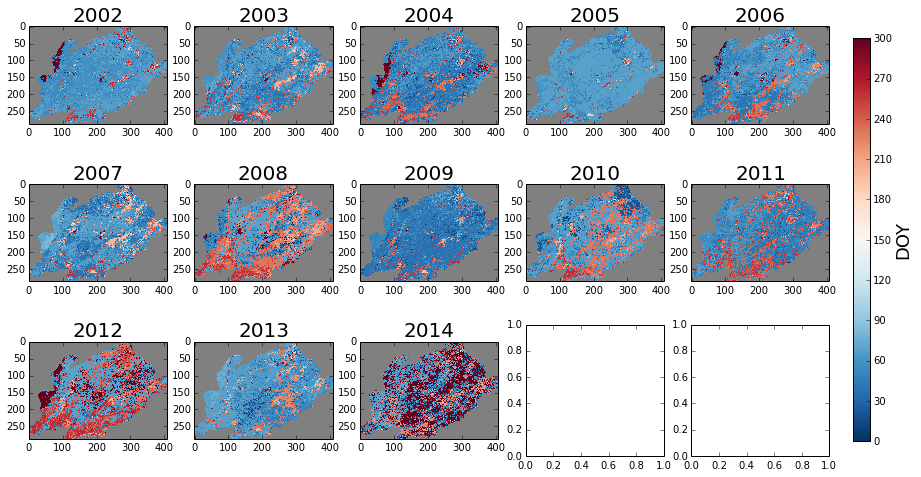

In [4]:
upper = ds.GetGeoTransform()[3]
lower = ds.GetGeoTransform()[3] + (float(ds.RasterYSize) * ds.GetGeoTransform()[-1])
left = ds.GetGeoTransform()[0]
right = ds.GetGeoTransform()[0] + (float(ds.RasterXSize) * ds.GetGeoTransform()[1])

ax = plt.figure(figsize=(20, 30))

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16, 8))

n = 2
for ax in axes.flat:
    path ="/home/faizan/Pakistan/EVI/20%02d/faislabad.20%02d_max_evi.tif" % (n,n)
    if os.path.exists(path) is True:
        ds = gdal.Open(path)
        array = ds.ReadAsArray()
        array[array == 0] = np.nan
        im = ax.imshow(array, vmax=300, vmin=0, interpolation="nearest", cmap=plt.cm.RdBu_r)
        ax.set_title("20%02d" % (n), fontsize=20) 
        ax.set_axis_bgcolor('grey')
        n += 1

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.84, 0.15, 0.015, 0.70])
CB = fig.colorbar(im, cax=cbar_ax)    
CB.set_label('DOY', fontsize=18)

plt.show()

Monthly Peak EVI value

In [5]:
ds = gdal.Open("/home/faizan/Pakistan/EVI/2002/faislabad.2002Jan_max_evi_value.tif")
array = ds.ReadAsArray()
array[array == 0] = np.nan

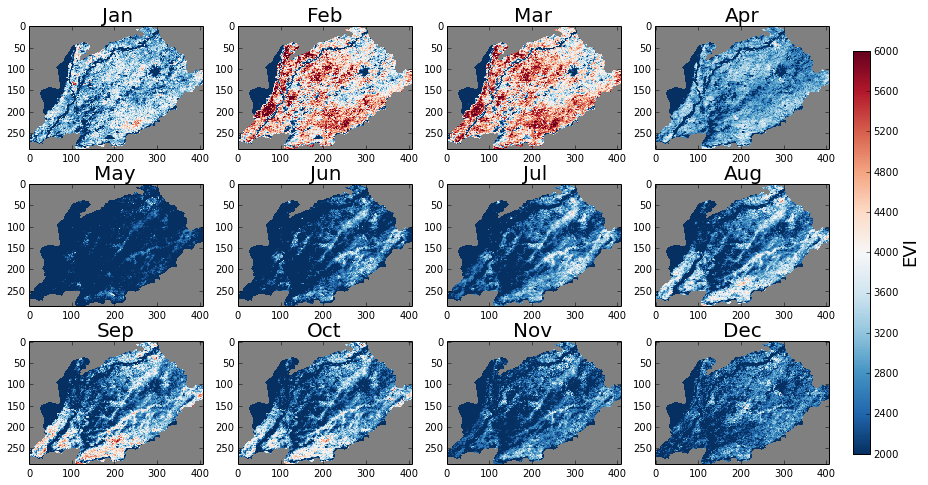

In [6]:
upper = ds.GetGeoTransform()[3]
lower = ds.GetGeoTransform()[3] + (float(ds.RasterYSize) * ds.GetGeoTransform()[-1])
left = ds.GetGeoTransform()[0]
right = ds.GetGeoTransform()[0] + (float(ds.RasterXSize) * ds.GetGeoTransform()[1])

ax = plt.figure(figsize=(20, 30))

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
year=2002
mon=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
n = 0
for ax in axes.flat:
    path ="/home/faizan/Pakistan/EVI/2002/faislabad.2002%s_max_evi_value.tif" % (mon[n])
    if os.path.exists(path) is True:
        ds = gdal.Open(path) 
        array = ds.ReadAsArray()
        array[array == 0] = np.nan
        im = ax.imshow(array, vmax=6000, vmin=2000, interpolation="nearest", cmap=plt.cm.RdBu_r)
        ax.set_title("%s" % (mon[n]), fontsize=20) 
        ax.set_axis_bgcolor('grey')
        n += 1

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.84, 0.15, 0.015, 0.70])
CB = fig.colorbar(im, cax=cbar_ax)    
CB.set_label('EVI', fontsize=18)

plt.show()

MAx EVI value kharif 

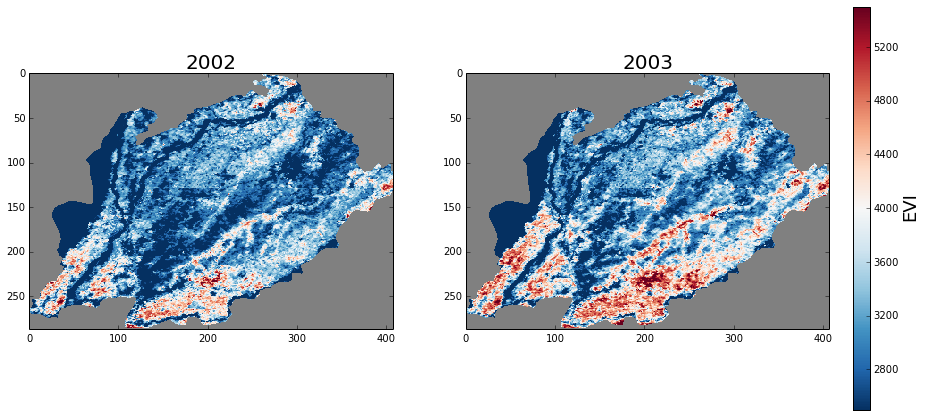

In [19]:
upper = ds.GetGeoTransform()[3]
lower = ds.GetGeoTransform()[3] + (float(ds.RasterYSize) * ds.GetGeoTransform()[-1])
left = ds.GetGeoTransform()[0]
right = ds.GetGeoTransform()[0] + (float(ds.RasterXSize) * ds.GetGeoTransform()[1])

ax = plt.figure(figsize=(20, 30))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

n = 2
for ax in axes.flat:
    path ="/home/faizan/Pakistan/EVI/20%02d/faislabad.20%02d.kharif_max_evi_value.tif" % (n,n)
    if os.path.exists(path) is True:
        ds = gdal.Open(path)
        array = ds.ReadAsArray()
        array[array == 0] = np.nan
        im = ax.imshow(array, vmax=5500, vmin=2500, interpolation="nearest", cmap=plt.cm.RdBu_r)
        ax.set_title("20%02d" % (n), fontsize=20) 
        ax.set_axis_bgcolor('grey')
        n += 1

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.84, 0.15, 0.015, 0.70])
CB = fig.colorbar(im, cax=cbar_ax)    
CB.set_label('EVI', fontsize=18)

plt.show()

Peak EVI date for Kharif (summer) 

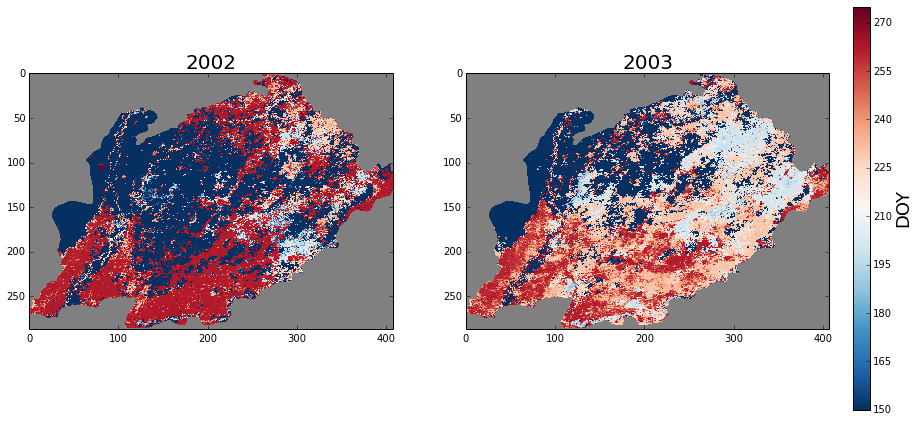

In [15]:
upper = ds.GetGeoTransform()[3]
lower = ds.GetGeoTransform()[3] + (float(ds.RasterYSize) * ds.GetGeoTransform()[-1])
left = ds.GetGeoTransform()[0]
right = ds.GetGeoTransform()[0] + (float(ds.RasterXSize) * ds.GetGeoTransform()[1])

ax = plt.figure(figsize=(20, 30))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

n = 2
for ax in axes.flat:
    path ="/home/faizan/Pakistan/EVI/20%02d/faislabad.20%02d.kharif_max_evi.tif" % (n,n)
    if os.path.exists(path) is True:
        ds = gdal.Open(path)
        array = ds.ReadAsArray()
        array[array == 0] = np.nan
        im = ax.imshow(array, vmax=275, vmin=150, interpolation="nearest", cmap=plt.cm.RdBu_r)
        ax.set_title("20%02d" % (n), fontsize=20) 
        ax.set_axis_bgcolor('grey')
        n += 1

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.84, 0.15, 0.015, 0.70])
CB = fig.colorbar(im, cax=cbar_ax)    
CB.set_label('DOY', fontsize=18)

plt.show()

MAx EVI value rabi

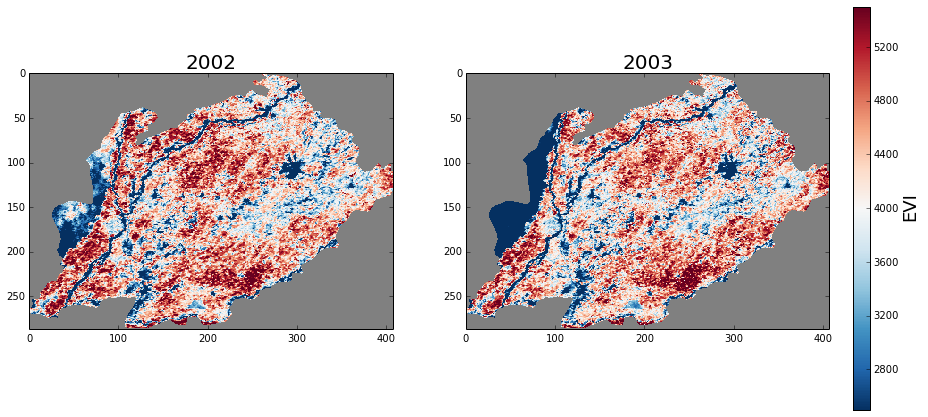

In [21]:
upper = ds.GetGeoTransform()[3]
lower = ds.GetGeoTransform()[3] + (float(ds.RasterYSize) * ds.GetGeoTransform()[-1])
left = ds.GetGeoTransform()[0]
right = ds.GetGeoTransform()[0] + (float(ds.RasterXSize) * ds.GetGeoTransform()[1])

ax = plt.figure(figsize=(20, 30))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

n = 2
for ax in axes.flat:
    path ="/home/faizan/Pakistan/EVI/20%02d/faislabad.20%02d.rabi_max_evi_value.tif" % (n,n)
    if os.path.exists(path) is True:
        ds = gdal.Open(path)
        array = ds.ReadAsArray()
        array[array == 0] = np.nan
        im = ax.imshow(array, vmax=5500, vmin=2500, interpolation="nearest", cmap=plt.cm.RdBu_r)
        ax.set_title("20%02d" % (n), fontsize=20) 
        ax.set_axis_bgcolor('grey')
        n += 1

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.84, 0.15, 0.015, 0.70])
CB = fig.colorbar(im, cax=cbar_ax)    
CB.set_label('EVI', fontsize=18)

plt.show()

Peak EVI date for rabi (winter) 

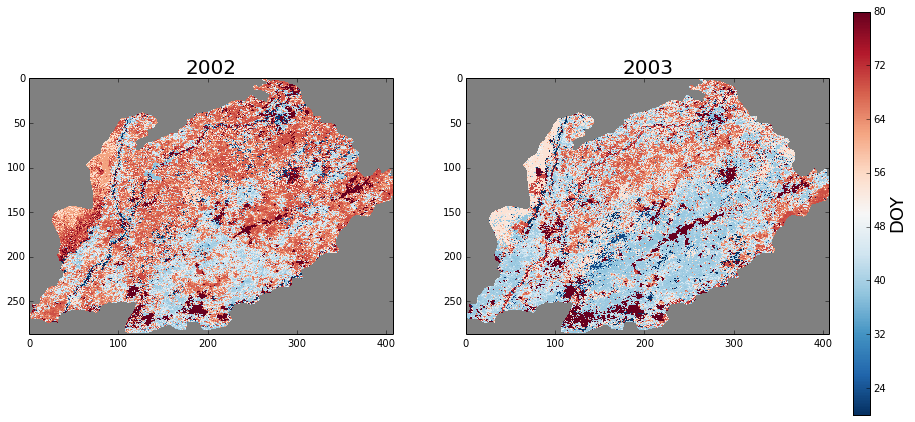

In [18]:
upper = ds.GetGeoTransform()[3]
lower = ds.GetGeoTransform()[3] + (float(ds.RasterYSize) * ds.GetGeoTransform()[-1])
left = ds.GetGeoTransform()[0]
right = ds.GetGeoTransform()[0] + (float(ds.RasterXSize) * ds.GetGeoTransform()[1])

ax = plt.figure(figsize=(20, 30))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

n = 2
for ax in axes.flat:
    path ="/home/faizan/Pakistan/EVI/20%02d/faislabad.20%02d.rabi_max_evi.tif" % (n,n)
    if os.path.exists(path) is True:
        ds = gdal.Open(path)
        array = ds.ReadAsArray()
        array[array == 0] = np.nan
        im = ax.imshow(array, vmax=80, vmin=20, interpolation="nearest", cmap=plt.cm.RdBu_r)
        ax.set_title("20%02d" % (n), fontsize=20) 
        ax.set_axis_bgcolor('grey')
        n += 1

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.84, 0.15, 0.015, 0.70])
CB = fig.colorbar(im, cax=cbar_ax)    
CB.set_label('DOY', fontsize=18)

plt.show()

In [60]:
ds = gdal.Open("/home/faizan/Pakistan/EVI/2002/Larkana.2002_max_evi.tif")
array = ds.ReadAsArray()
array[array == 0] = np.nan

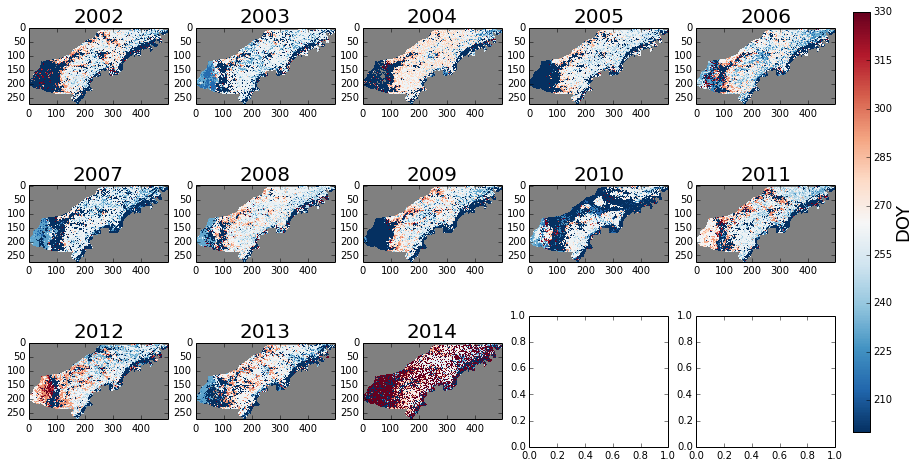

In [77]:
upper = ds.GetGeoTransform()[3]
lower = ds.GetGeoTransform()[3] + (float(ds.RasterYSize) * ds.GetGeoTransform()[-1])
left = ds.GetGeoTransform()[0]
right = ds.GetGeoTransform()[0] + (float(ds.RasterXSize) * ds.GetGeoTransform()[1])

ax = plt.figure(figsize=(20, 30))

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16, 8))

n = 2
for ax in axes.flat:
    path ="/home/faizan/Pakistan/EVI/20%02d/Larkana.20%02d_max_evi.tif" % (n,n)
    if os.path.exists(path) is True:
        ds = gdal.Open(path)
        array = ds.ReadAsArray()
        array[array == 0] = np.nan
        im = ax.imshow(array, vmax=330, vmin=200, interpolation="nearest", cmap=plt.cm.RdBu_r)
        ax.set_title("20%02d" % (n), fontsize=20) 
        ax.set_axis_bgcolor('grey')
        n += 1

fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.84, 0.15, 0.015, 0.73])
CB = fig.colorbar(im, cax=cbar_ax)    
CB.set_label('DOY', fontsize=18)

plt.show()